In the previous post, I showed how to build a number of bayesian regression models around the classic OC4 algorithm for estimating chlorophyll concentration from remote sensing reflectance data.

In this post I will introduce several concepts including
* varying effects
* hierarchical models sometimes referred to as partial pooling
* gaussian processes to introduce inference on potential covariance between unobserved variables (parameters).

Hierarchical modeling refers to the fact that the inference is conducted on multiple levels. The hierarchical structure is based on the notion that the data can be grouped into different clusters. The coefficients relevant to each cluster will have their own priors, drawn from a common set of *hyper priors*.

In [1]:
# Importing libraries
import pymc3 as pm
import numpy as np
import pandas as pd
import matplotlib.pyplot as pl
import seaborn as sb
import pickle
import theano.tensor as tt
from IPython.core.display import display, HTML

In [2]:
# Setting graphics...
% matplotlib inline
rc_ = {}
rc_['xtick.labelsize'] = 16
rc_['ytick.labelsize'] = 16
rc_['axes.formatter.limits'] = (-2, 3)
rc_['axes.labelsize'] = 16
rc_['font.size'] = 16
rc_['figure.titlesize'] = 20
rc_['axes.titlesize'] = 18
display(HTML("<style>.container {width: 90% !important}</style>"))
pl.style.use('bmh')

Below, I load training and testing datasets prepared and pickled earlier, in the previous post:

In [3]:
with open('./pickleJar/datasets.pkl', 'rb') as f:
    datasets = pickle.load(f)

In [4]:
df_train = datasets['swf']['train']
df_test = datasets['swf']['test']
del datasets

I'll refer to the test set at the very end. The data is the same as that used in the [previous post]():

In [5]:
df_train.head()

,id,mxBl2Gr,maxBlueId,chlor_a
0,1565,-0.267867,rrs510,1.581950
1,1566,-0.220457,rrs510,1.544192
2,1567,-0.268537,rrs510,1.429914
3,1568,-0.279976,rrs510,1.680879
4,1559,-0.167733,rrs510,1.371991


Notice the *maxBlueId* column. I'll return to that in a bit. For now, plotting the band ratio and chlor_a data pairwise yields:

No handles with labels found to put in legend.
No handles with labels found to put in legend.
/accounts/ekarakoy/anaconda3/lib/python3.6/site-packages/matplotlib/contour.py:967: UserWarning: The following kwargs were not used by contour: 'label', 'color'
  s)


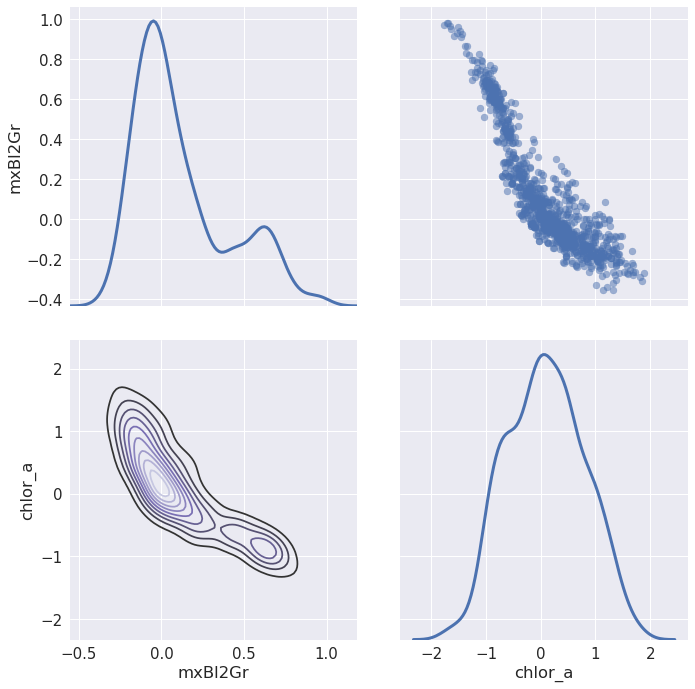

In [36]:
sb.set(font_scale=1.5)
g = sb.PairGrid(df_train, vars=['mxBl2Gr', 'chlor_a'], size=5, diag_sharey=False);
g = g.map_upper(pl.scatter,alpha=0.5)
g = g.map_diag(sb.kdeplot, lw=3)
g = g.map_lower(sb.kdeplot, cmap="Purples_d");

In the [previous post]() I implemented a few models that at their core pooled the data. Here I will explore this dataset's potential for clustering. For this I will use the *maxBlueId* shown above. 

The *maxBlueId* variable is categorical, and indicates which 'blue' band is used for the blue-to-green ratio of a given observation; 443, 490, or 510. 

First I plot the data pairwise, as above, this time introducing maxBlueId as a differentiation factor. Then I implement on-the-fly regressions to each cluster to visually inspect the tendencies of each. 

/accounts/ekarakoy/anaconda3/lib/python3.6/site-packages/matplotlib/contour.py:967: UserWarning: The following kwargs were not used by contour: 'label', 'color'
  s)


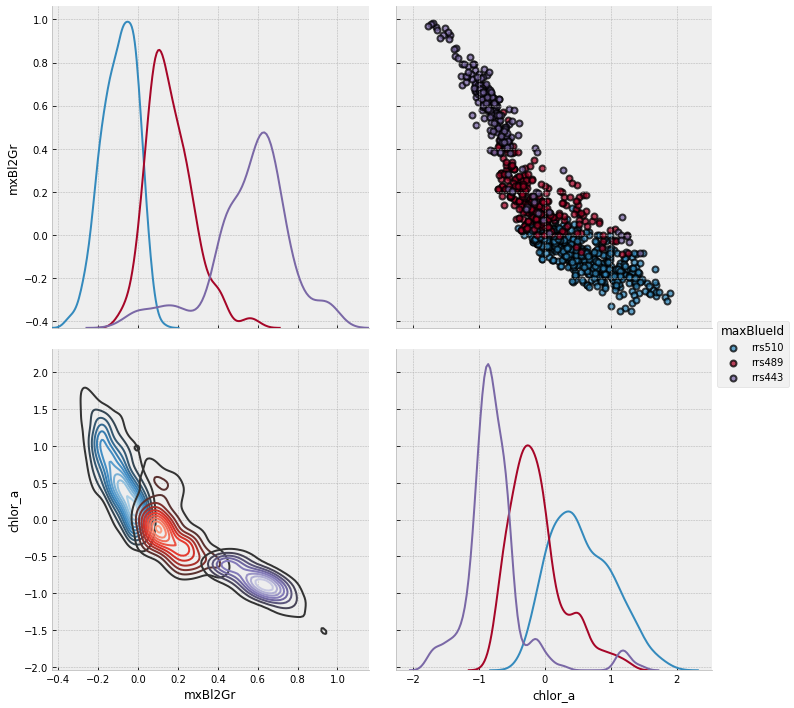

In [29]:
vars_ = ['mxBl2Gr', 'chlor_a']
g  = sb.PairGrid(df_train, vars=['mxBl2Gr', 'chlor_a'],size=5, diag_sharey=False,
                hue='maxBlueId',
                hue_kws={"cmap": ["Blues_d", "Reds_d", "Purples_d"]})
gupper = g.map_upper(pl.scatter, alpha=0.75, edgecolor='k', linewidth=2)
gdiag = g.map_diag(sb.kdeplot)
glower = g.map_lower(sb.kdeplot)
g.add_legend();

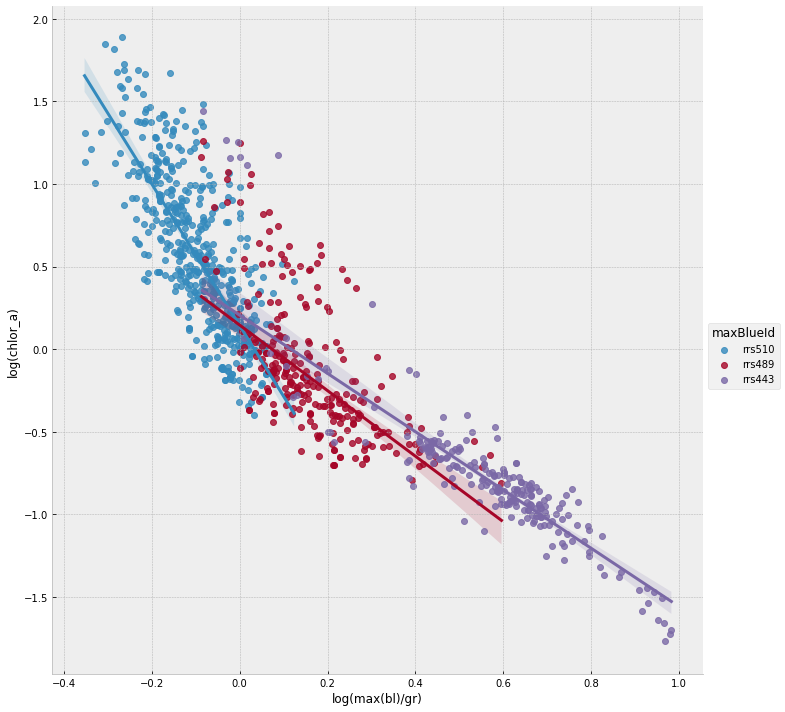

In [35]:
g = sb.lmplot(x="mxBl2Gr", y="chlor_a", hue="maxBlueId", truncate=True, size=10, data=df_train, robust=True)

# Use more informative axis labels than are provided by default
g.set_axis_labels("log(max(bl)/gr)", "log(chlor_a)");

I'll also check the allocation of the datapoints in each group:

In [37]:
df_train.maxBlueId.value_counts()

rrs510    523
rrs489    272
rrs443    221
Name: maxBlueId, dtype: int64

A number of observations can be drawn from these couple of cells above:

1. in spite of some overlap, these clusters seem well defined,
2. the progression of <u>lower chlorophyll to higher chlorophyll</u> follows a predictable rrs443$\rightarrow$rrs490$\rightarrow$rrs-510 progression,
3. some imbalance in the clustering exists, with the rrs510 cluster containing ~2x the data rrs489 and rrs443.

This invites one to ponder whether bias might be introduced from using a single, "pooled", regression line, leading to better inference in some domain of the input data than in others. Thus the remainder of this post examine:
* whether cluster-specific intercepts are significantly different
* whether cluster-specific slopes are significantly different
* whether clustering enables a simpler intra-cluster model than the stock high-order polynomial regression seen earlier.

Some additional terminology and concepts will be useful hereafter so I introduce them here.

The cluster- or group-specific intercept and slope(s) are commonly referred to as *varying intercept* and *varying slope*, respectively, and jointly as *varying effects* when both intercept and slope are concerned.

In addition to varying effects, I will introduce and use a **multilevel**, also referred to as **hierarchical**, or **partially pooled**, model structure. Rather than running inference independently on each cluster (a paradigm known as unpooled modeling) a multilevel structure allows information to flow between cluster-specific inference. This follows the reasonable assumption that the processes modeled withing each cluster, different though they might be in the details, are related to some significant degree. This has the benefit of tightening the resulting uncertainty intervals - a process known as *shrinkage*. It further benefits the inference of clusters that suffer from a relative paucity of data. 

In order to index into each cluster, I have to create a 0-indexed numerical category column of *maxBlueId*, which I do below:

In [8]:
df_train['max_blue_id_cat'] = df_train.maxBlueId.astype('category').cat.codes
df_train.tail()

,id,mxBl2Gr,maxBlueId,chlor_a,max_blue_id_cat
4454,6901,-0.111150,rrs510,0.665378,2
4455,6902,-0.053143,rrs489,0.471287,1
4456,6914,0.153314,rrs489,-0.021756,1
4457,6903,-0.097079,rrs510,0.657274,2
4458,6915,-0.176237,rrs510,0.763947,2


Now we can implement a first model, in the image of OC4 (see [previous post]()). I will use weakly regularizing priors. Note also that to save time, I precompute the polynomial imputs:

In [9]:
df_train['mxBl2Gr_2'] = df_train.mxBl2Gr**2
df_train['mxBl2Gr_3'] = df_train.mxBl2Gr**3
df_train['mxBl2Gr_4'] = df_train.mxBl2Gr**4

In [10]:
df_train.head()

,id,mxBl2Gr,maxBlueId,chlor_a,max_blue_id_cat,mxBl2Gr_2,mxBl2Gr_3,mxBl2Gr_4
0,1565,-0.267867,rrs510,1.581950,2,0.071753,-0.019220,0.005148
1,1566,-0.220457,rrs510,1.544192,2,0.048601,-0.010714,0.002362
2,1567,-0.268537,rrs510,1.429914,2,0.072112,-0.019365,0.005200
3,1568,-0.279976,rrs510,1.680879,2,0.078386,-0.021946,0.006144
4,1559,-0.167733,rrs510,1.371991,2,0.028134,-0.004719,0.000792


In [11]:
df_train.max_blue_id_cat.unique().size
x_input = df_train.as_matrix(columns=['mxBl2Gr%s' %i for i in ['', '_2','_3','_4']])
cl_idx = df_train.max_blue_id_cat.values

In [75]:
# verify cluster index content
np.unique(cl_idx)

array([0, 1, 2], dtype=int8)

In [77]:
x_input.shape

(1016, 4)

In [73]:
# check the right columns were grabbed
x_input[:3]

array([[-0.26786697,  0.07175271, -0.01922018,  0.00514845],
       [-0.22045677,  0.04860119, -0.01071446,  0.00236208],
       [-0.26853699,  0.07211211, -0.01936477,  0.00520016]])

### Varying Intercepts

A regression problem, where the data can be split into clusters, can be be given an improved solution by computing cluster-specific regression parameters. Varying intercepts is one such approach, where the clusters share a common slope but the intercepts are cluster-specific. The model below shows this approach.

In [21]:
n_clusters = df_train.max_blue_id_cat.unique().size
clust_idx = df_train.max_blue_id_cat.values

with pm.Model() as m_vi:
    
    # priors
    alpha_clust = pm.Normal('alpha', mu=0, sd=10, shape=n_clusters)
    beta = pm.Normal('beta', mu=0, sd=10)
    sigma = pm.HalfCauchy('sigma', 2)
    
    # deterministic form of the model
    mu_ = alpha_clust[clust_idx] + beta * df_train.mxBl2Gr.values
    
    # likelihood
    chlor_a = pm.Normal('chlor_a', mu=mu_, sd=sigma, observed=df_train.chlor_a.values)
    
    # sample
    trace_m_vi = pm.sample(5000, tune=1000, nuts_kwargs={'target_accept': 0.95})

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma_log__, beta, alpha]
100%|██████████| 6000/6000 [00:13<00:00, 448.22it/s]


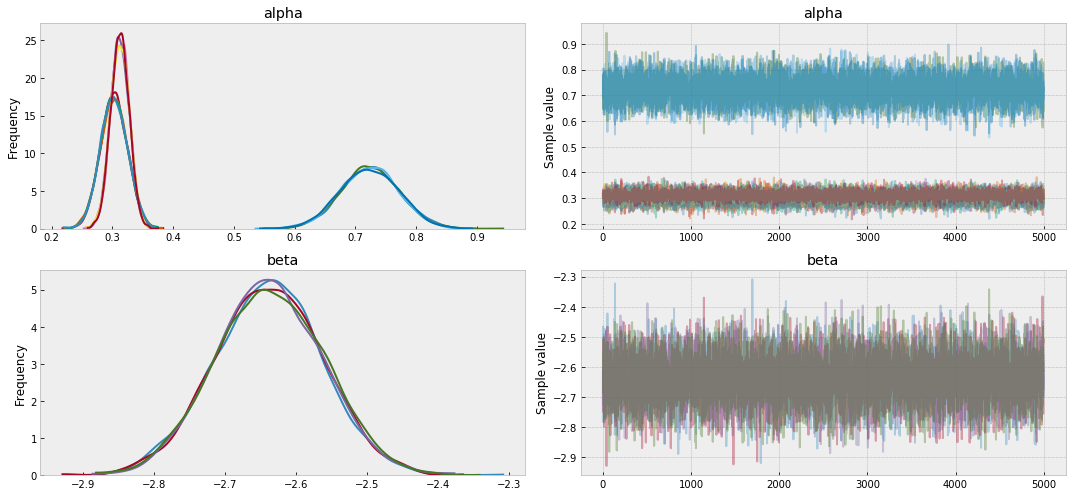

In [25]:
pm.traceplot(trace_m_vi, varnames=['alpha', 'beta'], figsize=(15, 7));

### Varying Effects:

The traces above show that one cluster has a significantly different intercept. However the single slope may hinder the inference. Model flexibility can be added by incorporating cluster-specific slopes as well. The presence of both group-based slopes and group-based intercepts is referred to by the more general term of *varying effects*

The implementation of varying effects is shown below:

In [31]:
with pm.Model() as m_ve:
    
    # priors
    alpha_clust = pm.Normal('alpha', mu=0, sd=1, shape=n_clusters)
    beta = pm.Normal('beta', mu=0, sd=1, shape=n_clusters)
    sigma = pm.HalfCauchy('sigma', 2)
    
    # deterministic form of the model
    mu_ = alpha_clust[clust_idx] + beta[clust_idx] * df_train.mxBl2Gr.values
    
    # likelihood
    chlor_a = pm.Normal('chlor_a', mu=mu_, sd=sigma, observed=df_train.chlor_a.values)
    
    # sample
    trace_m_ve = pm.sample(5000, tune=1000, nuts_kwargs={'target_accept': 0.95})

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma_log__, beta, alpha]
100%|██████████| 6000/6000 [00:19<00:00, 309.59it/s]


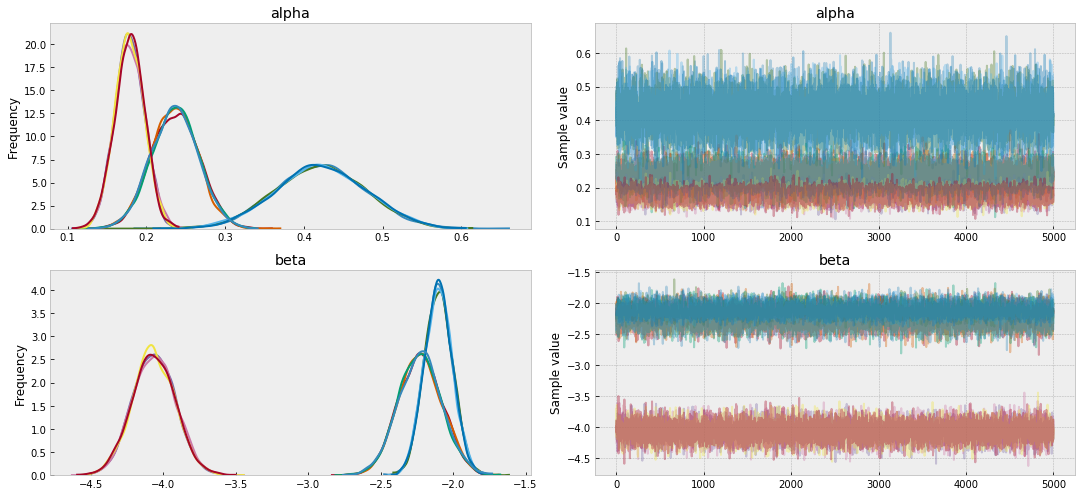

In [34]:
pm.traceplot(trace_m_ve, varnames=['alpha', 'beta'], figsize=(15, 7));

### Partial Pooling


### Gaussian Processes
